## Google Analytics Customer Revenue
필사 시작일 : 2020-12-29 <br>
출처 :https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue

**Objective of the notebook:**

주어진 데이터셋을 탐색하고, gbm model을 구축해볼것이다.

**Objective of the competition:**

대회 목적은 Google Merchandise Store 의 고객 데이터를 분석해서 고객당 수익을 예측하는 것이다.

### process정리
* json포맷의 데이터를 flatten하게 변경 
    * json.loads,json_normalize활용
* 타겟변수인 총 거래수익 (totals.transactionRevenue) 탐색
    * 소수의 고객이 대부분의 수익을 차지하고있음
* train set과 test set에서 공통적으로 있는 사용자 id 체크
* 컬럼내의 unique한 값이 1개뿐인 feature들 제거


In [ ]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

**About the dataset:**

Similar to most other kaggle competitions, we are given two datasets
* train.csv
* test.csv

Each row in the dataset is one visit to the store. We are predicting the natural log of the sum of all transactions per user. 
    
The data fields in the given files are 
* fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
* channelGrouping - The channel via which the user came to the Store.
* date - The date on which the user visited the Store.
* device - The specifications for the device used to access the Store.
* geoNetwork - This section contains information about the geography of the user.
* sessionId - A unique identifier for this visit to the store.
* socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
* totals - This section contains aggregate values across the session.
* trafficSource - This section contains information about the Traffic Source from which the session originated.
* visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
* visitNumber - The session number for this user. If this is the first session, then this is set to 1.
* visitStartTime - The timestamp (expressed as POSIX time).

Also it is important to note that some of the fields are in json format. 

Thanks to this [wonderful kernel](https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook) by [Julian](https://www.kaggle.com/julian3833), we can convert all the json fields in the file to a flattened csv format which generally use in other competitions.

In [9]:
# device, geoNetwork, totals, trafficSource같은 json포맷 데이터를 key,value로 떼어내서 컬럼생성하는 함수.

def load_df(csv_path='../input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    # JSON 데이터를 python으로 읽기 => json.loads
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])   # json_normalize: json포맷인 컬럼만 flatten하게 만들어준것.
        # 컬럼명을 '기존컬럼명.서브컬럼명' 으로변경
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        # 원본 데이터프레임에서 json포맷컬럼은 drop하고, 새로 flatten한 컬럼을 merge해서 붙여줌.
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [11]:
# JSON 데이터를 python으로 읽기 => json.loads
JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
df=pd.read_csv('../input/train.csv',
              converters={column: json.loads for column in JSON_COLUMNS},
              dtype={'fullVisitorId':'str'},
              nrows=None)
df

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",1131660440785968503,"{'continent': 'Asia', 'subContinent': 'Western...",1131660440785968503_1472830385,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472830385,1,1472830385
1,Organic Search,20160902,"{'browser': 'Firefox', 'browserVersion': 'not ...",377306020877927890,"{'continent': 'Oceania', 'subContinent': 'Aust...",377306020877927890_1472880147,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472880147,1,1472880147
2,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",3895546263509774583,"{'continent': 'Europe', 'subContinent': 'South...",3895546263509774583_1472865386,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472865386,1,1472865386
3,Organic Search,20160902,"{'browser': 'UC Browser', 'browserVersion': 'n...",4763447161404445595,"{'continent': 'Asia', 'subContinent': 'Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472881213,1,1472881213
4,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",27294437909732085,"{'continent': 'Europe', 'subContinent': 'North...",27294437909732085_1472822600,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472822600,2,1472822600
5,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",2938943183656635653,"{'continent': 'Europe', 'subContinent': 'South...",2938943183656635653_1472807194,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472807194,1,1472807194
6,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",1905672039242460897,"{'continent': 'Asia', 'subContinent': 'Souther...",1905672039242460897_1472817241,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472817241,1,1472817241
7,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",537222803633850821,"{'continent': 'Oceania', 'subContinent': 'Aust...",537222803633850821_1472812602,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472812602,1,1472812602
8,Organic Search,20160902,"{'browser': 'Internet Explorer', 'browserVersi...",4445454811831400414,"{'continent': 'Europe', 'subContinent': 'Weste...",4445454811831400414_1472805784,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472805784,1,1472805784
9,Organic Search,20160902,"{'browser': 'Firefox', 'browserVersion': 'not ...",9499785259412240342,"{'continent': 'Europe', 'subContinent': 'Weste...",9499785259412240342_1472812272,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472812272,1,1472812272


In [17]:
# 아래 결과는 json포맷인 컬럼만 flatten하게 만들어준것.
JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
for column in JSON_COLUMNS:
    column_as_df=json_normalize(df[column])
column_as_df

,adContent,adwordsClickInfo.adNetworkType,adwordsClickInfo.criteriaParameters,adwordsClickInfo.gclId,adwordsClickInfo.isVideoAd,adwordsClickInfo.page,adwordsClickInfo.slot,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source
0,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google
5,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
6,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
7,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
8,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
9,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google


In [ ]:
# 그냥 csv 파일로 읽어올수도있음.
df=pd.read_csv('../input/train.csv',nrows=None)
df.head()

In [ ]:
%%time
train_df = load_df()
test_df = load_df("../input/test.csv")

In [8]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not a

In [74]:
train_df.to_csv('train_df.csv')

**타겟변수 탐색:**

우리는 모든 유저의 총 거래량의 합계 데이터를 예측하고있기 때문에, 거래수입을 유저 레벨에서 모두 더하고 로그를 취해서 scatter plot을 그려보자.

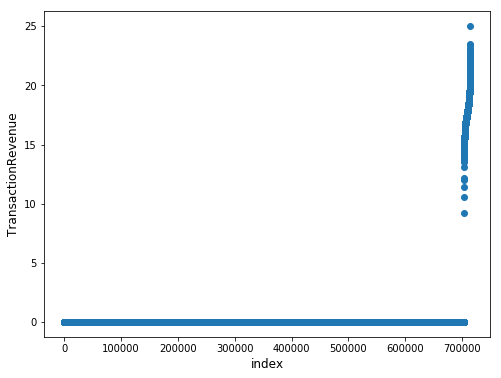

In [24]:
train_df['totals.transactionRevenue']=train_df['totals.transactionRevenue'].astype('float')
# id별 거래수익 합계를 구함.
gdf=train_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()

plt.figure(figsize=(8,6))
# range로 행을 지정
plt.scatter(range(gdf.shape[0]),np.sort(np.log1p(gdf['totals.transactionRevenue'].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

80:20법칙과 같이 위 그림도 특정 사용자가 대부분의 수익을 차지하는 것을 알 수 있다. <br>
그러므로, 마케팅팀은 프로모션 전략에 적절한 투자를 하는것을 시도한다.

In [38]:
nzi=pd.notnull(train_df['totals.transactionRevenue']).sum()
nzr=(gdf['totals.transactionRevenue']>0).sum()
print('수익이 0이 아닌 row의 수:', nzi, '비율은 :',nzi/train_df.shape[0])
print('수익이 0보다 큰 유니크한 사용자의 수:',nzr, '비율은:', nzr/gdf.shape[0])  # gdf는 유저id별로 그룹핑한 데이터프레임

수익이 0이 아닌 row의 수: 11515 비율은 : 0.0127427231470487
수익이 0보다 큰 유니크한 사용자의 수: 9996 비율은: 0.013996726255903731


* 수익이 0이아닌 사용자 비중은 1.3%
* 수익이 0이 아닌것에서 각 변수별 카테고리별 카운트를 살펴보자

**방문자수와 공통 방문자 수**
* train,test데이터에서 유니크한 방문자수와 공통 방문자수를 살펴보자.

In [39]:
print('train set에서 유니크한 방문자수:', train_df.fullVisitorId.nunique(), "out of rows:", train_df.shape[0])
print('test set 에서 유니크한 방문자수:', test_df.fullVisitorId.nunique(),"out of rows:", test_df.shape[0])
print('train과 test에서 공통 방문자수:',len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique()))))

train set에서 유니크한 방문자수: 714167 out of rows: 903653
test set 에서 유니크한 방문자수: 617242 out of rows: 804684
train과 test에서 공통 방문자수: 7679


**Columns with constant values**
* train set에 변함없는 몇몇 feature들이 보인다. 이러한 feature들의 리스트를 봐보자. constant값과 null값은 포함하지않고 봐보자.

In [55]:
# 컬럼내의 결측치를 제거한 유니크한 값이 1개만있는경우
const_cols=[c for c in train_df.columns if train_df[c].nunique(dropna=False)==1]
const_cols

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

* 유니크한 값이 1개밖에 없는 컬럼들은 메모리와 시간을 절약하기위해 drop하는것으로 결정.

**Device Information:**

In [ ]:
# plotly
def horizontal_bar_chart(cnt_srs,color):
    trace=go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False

In [70]:
# plotly 안보임.
trace=go.Bar(y=cnt_srs.head(10).index,
      x=cnt_srs.head(10).values,
      showlegend=False,
      orientation='h')
fig=tools.make_subplots(rows=1,cols=1)
fig.append_trace(trace,1,1)
py.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]



In [87]:
# plotly말고 그냥 matplotlib이나 seaborn으로 그려보기
## size()는 NaN값도 포함해서 카운트, count()는 NaN아닌값만 카운트

# Device Browser => Chrome, Safari, Firefox IE
cnt_brws=train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_brws.columns=['count','count of non-zero revenue','mean']
cnt_brws=cnt_brws.sort_values(by='count',ascending=False)

# Device Category=> desktop, mobile, tablet
cnt_cat=train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_cat.columns=['count','count of non-zero revenue','mean']
cnt_cat=cnt_cat.sort_values(by='count',ascending=False)


# Operating system =>Windows, Macintosh, Android, iOS
cnt_sys=train_df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_sys.columns=['count','count of non-zero revenue','mean']
cnt_sys=cnt_sys.sort_values(by='count',ascending=False)
cnt_sys.head()

,count,count of non-zero revenue,mean
device.operatingSystem,,,
Windows,350072,2309,1.720713e+08
Macintosh,253938,6426,1.332673e+08
Android,123892,467,7.781859e+07
iOS,107665,536,4.135616e+07
Linux,35034,782,5.615141e+07


In [107]:
cnt_brws['count'].head(10)

device.browser
Chrome               620364
Safari               182245
Firefox               37069
Internet Explorer     19375
Edge                  10205
Android Webview        7865
Safari (in-app)        6850
Opera Mini             6139
Opera                  5643
UC Browser             2427
Name: count, dtype: int64

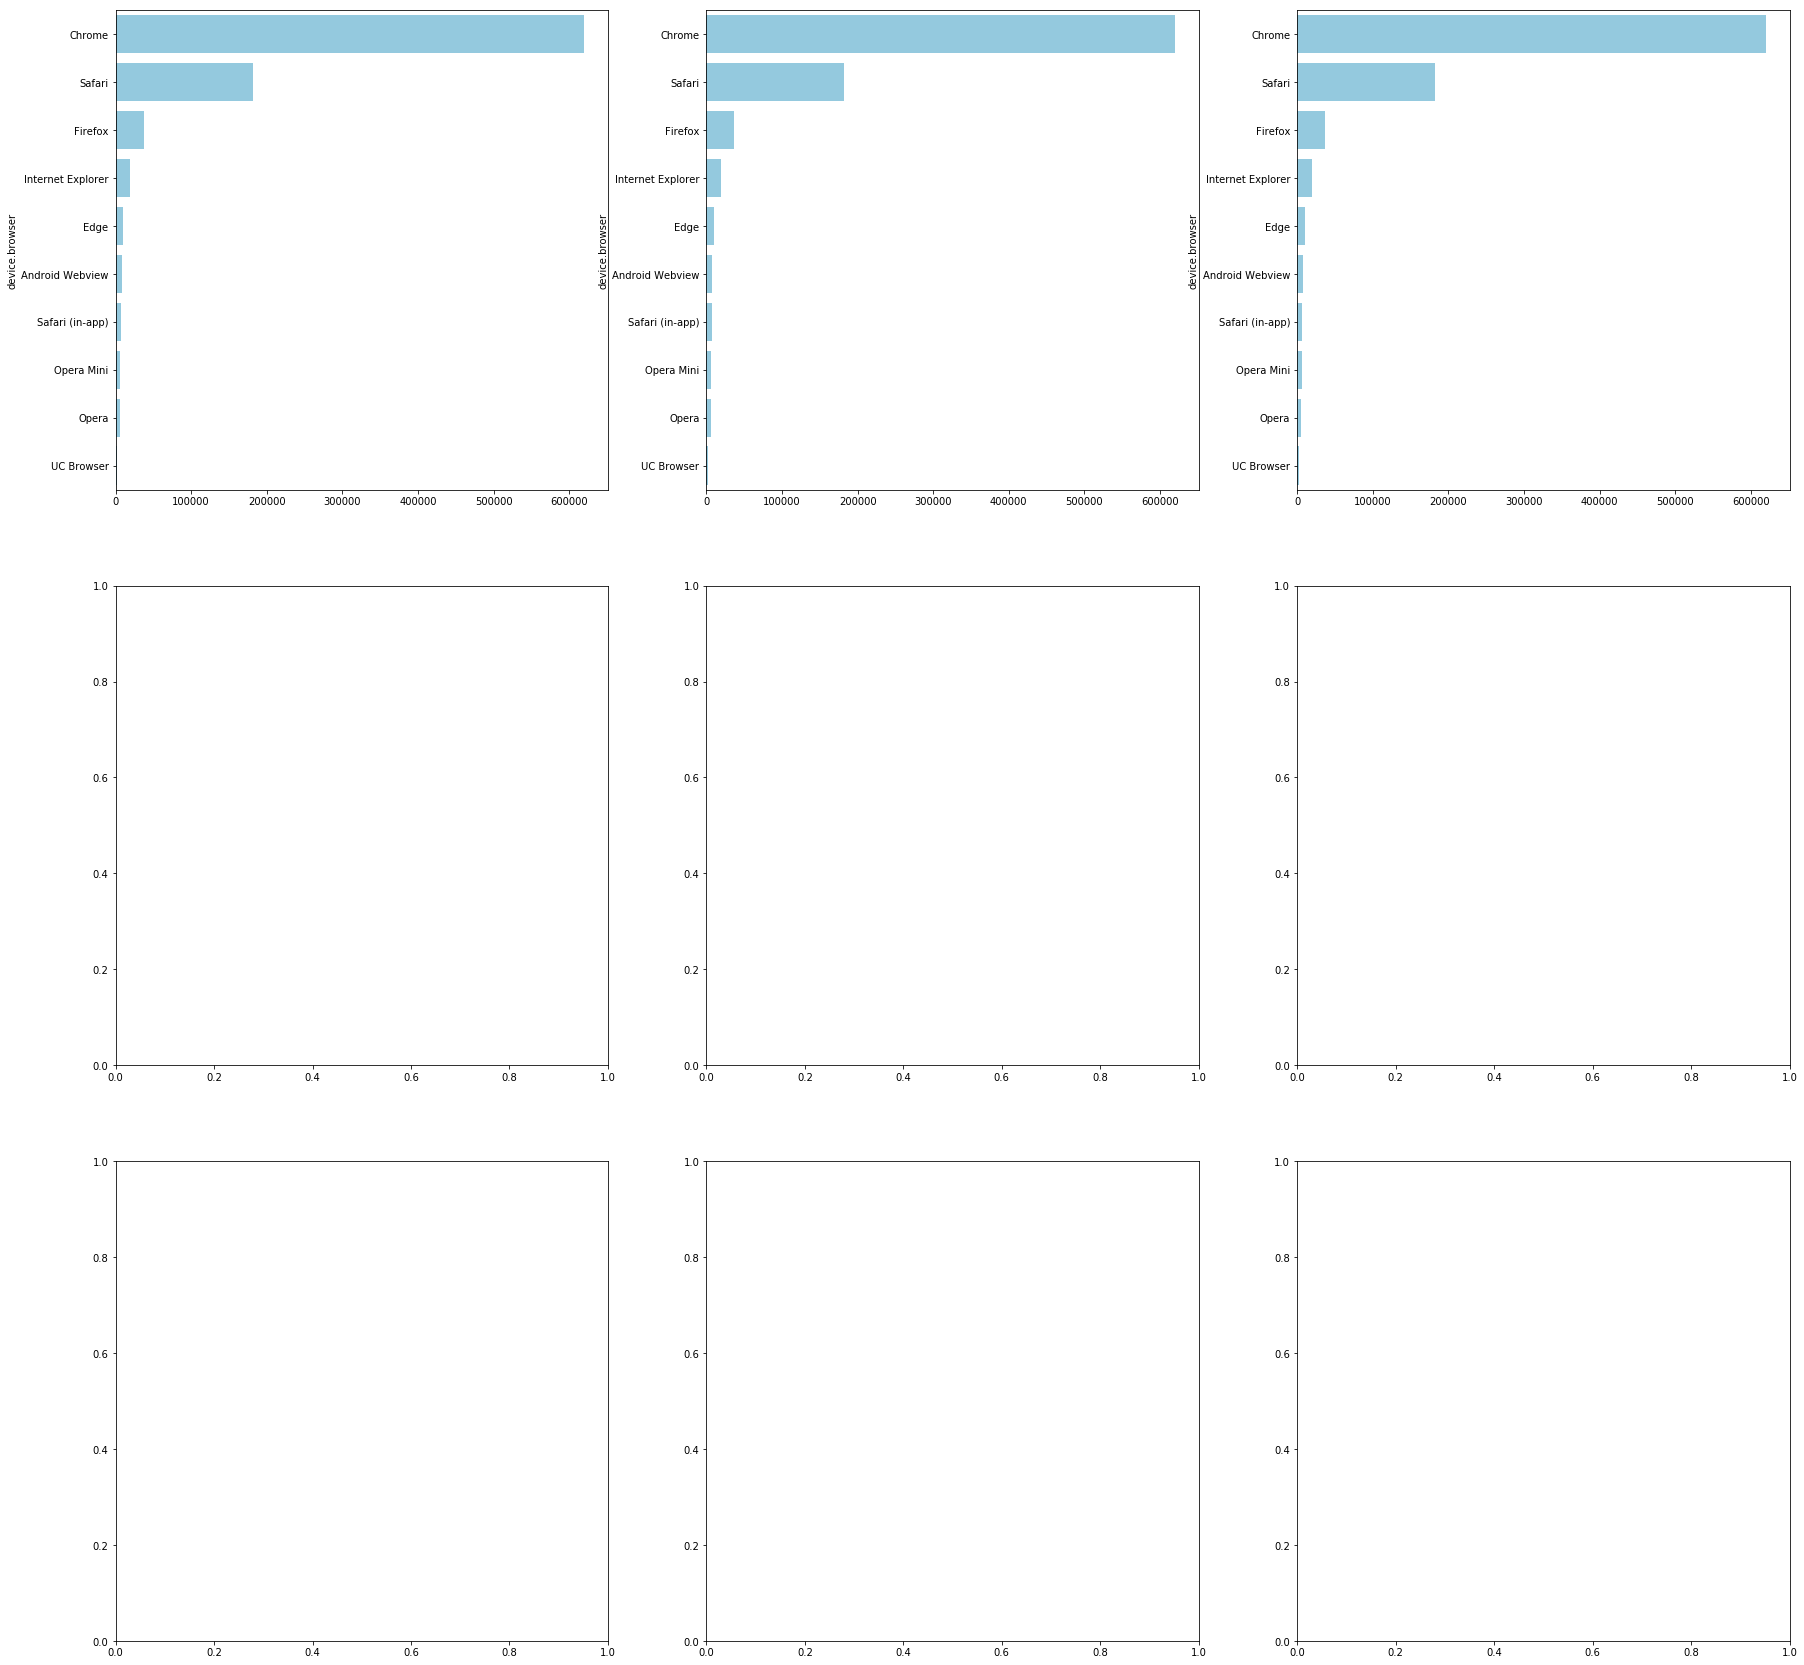

In [127]:
# 3x3그래프그리기
fig,ax=plt.subplots(nrows=3,ncols=3)
fig.set_size_inches(30,30)
sns.barplot(x=cnt_brws['count'].head(10).values, y=cnt_brws['count'].head(10).index, orient='h',color='skyblue',ax=ax[0][0])
sns.barplot(x=cnt_brws['count of non-zero revenue'].head(10).values, y=cnt_brws['count of non-zero revenue'].head(10).index, orient='h',color='skyblue',ax=ax[0][1])
sns.barplot(x=cnt_brws['mean'].head(10).values, y=cnt_brws['mean'].head(10).index, orient='h',color='skyblue',ax=ax[0][2]);


